## Import datasetu

In [ ]:
!gdown --id 14Y4mRzFCp5hTJL9jtKGepvW8W9XP2c7j

Downloading...
From: https://drive.google.com/uc?id=14Y4mRzFCp5hTJL9jtKGepvW8W9XP2c7j
To: /content/ballnoball.zip
85.6MB [00:00, 93.5MB/s]


In [ ]:
!unzip ballnoball.zip

## Import bibliotek

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import time
import copy
import os

##Generacja i augmentacja danych

Stworzenie zbioru danych opartego o zbior obrazów w którym każda klasa zapisana jest w osobnym folderze. Przygotowanie generatorów wsadów (minibatch) do uczenia, walidacji oraz testowania sieci wraz z odpowiednią augumentacją danych.

In [ ]:
data_dir = '/content/ballnoball'

train_transforms = transforms.Compose([
                                transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(data_dir + '/train',  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(data_dir + '/test', 
                                    transform=test_transforms)


image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir + '/train', transform=train_transforms),
    'validation': 
    datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  
}

## Trenowanie modelu

In [ ]:
batch_size = 128
learning_rate = 1e-3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss: 0.0749, acc: 0.9697
validation loss: 0.3841, acc: 0.8537
Epoch 2/10
----------
train loss: 0.0454, acc: 0.9844
validation loss: 0.0903, acc: 0.9756
Epoch 3/10
----------
train loss: 0.0074, acc: 0.9979
validation loss: 0.0411, acc: 0.9909
Epoch 4/10
----------
train loss: 0.0127, acc: 0.9968
validation loss: 0.0407, acc: 0.9878
Epoch 5/10
----------
train loss: 0.0040, acc: 0.9987
validation loss: 0.0563, acc: 0.9878
Epoch 6/10
----------
train loss: 0.0330, acc: 0.9871
validation loss: 0.0429, acc: 0.9848
Epoch 7/10
----------
train loss: 0.0045, acc: 0.9989
validation loss: 0.0438, acc: 0.9939
Epoch 8/10
----------
train loss: 0.0077, acc: 0.9976
validation loss: 0.0537, acc: 0.9787
Epoch 9/10
----------
train loss: 0.0037, acc: 0.9989
validation loss: 0.0577, acc: 0.9909
Epoch 10/10
----------
train loss: 0.0037, acc: 0.9987
validation loss: 0.0435, acc: 0.9909


wytrenowano wagi klasyfikatora do skuteczności walidacyjnej na poziomie 99%

## Predykcje dowolnych obrazów z datasetu

In [ ]:
validation_img_paths = ["/content/ballnoball/test/Ball/cropped_ball_dataset_2_16_1.jpg",
                        "/content/ballnoball/test/Ball/cropped_ball_dataset_2_27_1.jpg",
                        "/content/ballnoball/test/Noball/P1030152.JPG",
                        "/content/ballnoball/test/Noball/image_0620.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [ ]:
validation_batch = torch.stack([test_transforms(img).to(device) for img in img_list])

In [ ]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 5.9959, -7.6809],
        [ 2.4042, -2.9042],
        [-4.6325,  5.4728],
        [-3.5392,  4.3294]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.9999881e-01, 1.1487531e-06],
       [9.9507457e-01, 4.9253819e-03],
       [4.0858518e-05, 9.9995911e-01],
       [3.8243443e-04, 9.9961758e-01]], dtype=float32)

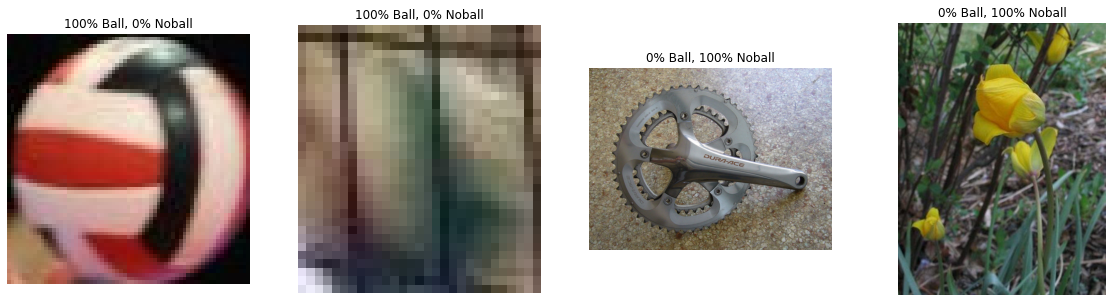

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Ball, {:.0f}% Noball".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

In [ ]:
torch.save(model_trained.state_dict(), 'weights.h5')

Zapisane wagi modelu - wykorzystane dalej do użycia przy feature extractorze algorytmu Deepsort